In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE

Read the dataset from csv file

In [24]:
stroke_df = pd.read_csv("dataset/stroke-dataset.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [25]:
print(stroke_df["gender"].unique())
print(stroke_df["ever_married"].unique())
print(stroke_df["work_type"].unique())
print(stroke_df["Residence_type"].unique())
print(stroke_df["smoking_status"].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Check for null values

In [26]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Drop rows with null values

In [27]:
stroke_df.dropna(how='any', axis=0, inplace=True)
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [28]:
stroke_df.drop(['id', 'ever_married', 'work_type', 'Residence_type'], axis=1, inplace=True)

Check for invalid values for glucose level and bmi

In [29]:
print(sum(stroke_df["bmi"] <= 0))
print(sum(stroke_df["avg_glucose_level"] <= 0))
print(max(stroke_df["bmi"]))
print(min(stroke_df["bmi"]))
print(max(stroke_df["avg_glucose_level"]))
print(min(stroke_df["avg_glucose_level"]))
print(max(stroke_df["age"]))
print(min(stroke_df["age"]))

0
0
97.6
10.3
271.74
55.12
82.0
0.08


In [30]:
def one_hot_encoder_two(data,feature,keep_first=True):

    one_hot_cols = pd.get_dummies(data[feature])
    
    for col in one_hot_cols.columns:
        one_hot_cols.rename({col:f'{feature}_'+col},axis=1,inplace=True)
    
    new_data = pd.concat([data,one_hot_cols],axis=1)
    new_data.drop(feature,axis=1,inplace=True)
    
    if keep_first == False:
        new_data=new_data.iloc[:,1:]
    
    return new_data

In [31]:
stroke_df_copy = stroke_df.copy()
for col in stroke_df_copy.select_dtypes(include='O').columns:
    stroke_df_copy = one_hot_encoder_two(stroke_df_copy, col)

stroke_df_copy.reset_index(inplace=True, drop=True)
stroke_df_copy.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,False,True,False,False,True,False,False
1,80.0,0,1,105.92,32.5,1,False,True,False,False,False,True,False
2,49.0,0,0,171.23,34.4,1,True,False,False,False,False,False,True
3,79.0,1,0,174.12,24.0,1,True,False,False,False,False,True,False
4,81.0,0,0,186.21,29.0,1,False,True,False,False,True,False,False


In [32]:
stroke_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4909 non-null   float64
 1   hypertension                    4909 non-null   int64  
 2   heart_disease                   4909 non-null   int64  
 3   avg_glucose_level               4909 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          4909 non-null   int64  
 6   gender_Female                   4909 non-null   bool   
 7   gender_Male                     4909 non-null   bool   
 8   gender_Other                    4909 non-null   bool   
 9   smoking_status_Unknown          4909 non-null   bool   
 10  smoking_status_formerly smoked  4909 non-null   bool   
 11  smoking_status_never smoked     4909 non-null   bool   
 12  smoking_status_smokes           49

In [33]:
for col in stroke_df_copy.select_dtypes(include='bool').columns:
    stroke_df_copy[col] = stroke_df_copy[col].replace({True:1, False:0})

stroke_df_copy.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,1,0,0


In [39]:
stroke_df_smoking_unknown = stroke_df_copy[stroke_df_copy["smoking_status_Unknown"] == 1]
stroke_df_smoking_unknown

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
7,78.0,0,0,58.57,24.2,1,1,0,0,1,0,0,0
19,82.0,0,1,208.30,32.5,1,0,1,0,1,0,0,0
25,42.0,0,0,83.41,25.4,1,0,1,0,1,0,0,0
32,58.0,0,0,92.62,32.0,1,0,1,0,1,0,0,0
54,76.0,0,0,104.47,20.3,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4899,9.0,0,0,71.88,17.5,0,0,1,0,1,0,0,0
4901,45.0,0,0,97.95,24.5,0,1,0,0,1,0,0,0
4903,18.0,0,0,82.85,46.9,0,1,0,0,1,0,0,0
4904,13.0,0,0,103.08,18.6,0,1,0,0,1,0,0,0


In [17]:
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 'gender_Other',
            'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']

X = stroke_df_copy[features]
Y = stroke_df_copy['stroke']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(3436, 12)
(1473, 12)


In [19]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [20]:
print(X_train_res.shape)
print(y_train_res.shape)
print(sum(y_train_res == 1))
print(sum(y_train_res == 0))

(6564, 12)
(6564,)
3282
3282


In [21]:
y_test.value_counts(normalize=True)

stroke
0    0.962661
1    0.037339
Name: proportion, dtype: float64

c:\Training\django\django_day10\day10_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Training\django\django_day10\day10_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1418
           1       0.16      0.35      0.22        55

    accuracy                           0.91      1473
   macro avg       0.57      0.64      0.59      1473
weighted avg       0.94      0.91      0.92      1473



c:\Training\django\django_day10\day10_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Training\django\django_day10\day10_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

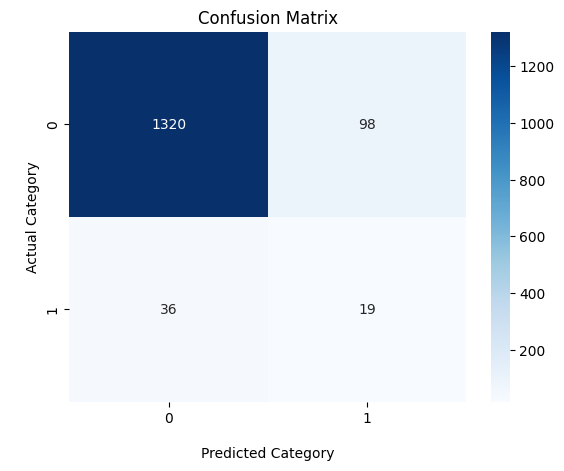

In [41]:
# dt = DecisionTreeClassifier(criterion='entropy')
# dt.fit(X_train_res, y_train_res.ravel())
# y_pred = dt.predict(X_test)

lr = LogisticRegression()
lr.fit(X_train_res, y_train_res.ravel())
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

# CalibratedClassifierCV for getting the probability distribution of predictions
calibrated_clf = CalibratedClassifierCV(lr, method='sigmoid')
calibrated_clf.fit(X_train_res, y_train_res.ravel())

predict_probabilities = calibrated_clf.predict_proba(X_test)

# model_filename = "stroke_risk_clf.joblib"
# calibrated_clf_filename = "stroke_risk_calibrated_clf.joblib"
# joblib.dump(lr, "models/" + model_filename)
# joblib.dump(calibrated_clf, "models/" + calibrated_clf_filename)

confusion_matr = confusion_matrix(y_test, y_pred)
confusion_matr = sns.heatmap(confusion_matr, annot=True, cmap='Blues', fmt='d')

confusion_matr.set_title("Confusion Matrix")
confusion_matr.set_xlabel("\nPredicted Category")
confusion_matr.set_ylabel("\nActual Category")

plt.show()

